In [47]:
import numpy as np
import math
import matplotlib.pyplot as plt
from pathlib import Path
from topostats.io import LoadScans
import topostats.filters as topofilters
from topostats.utils import get_mask
from scipy.optimize import least_squares
from scipy.interpolate import splprep, splev
from scipy.spatial import distance
#from skimage.filters import gaussian
#from skimage.filters import threshold_otsu
#from skimage.morphology import binary_erosion
#from skimage.morphology import remove_small_objects, label
#from skimage.measure import regionprops
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line
from skimage.color import rgb2gray
from scipy import ndimage
from scipy.spatial.distance import cdist
from skimage.morphology import label
from skimage import draw
import csv

In [ ]:
def plot(image: np.ndarray, title: str=None, zlimit: bool=True, figsize: tuple=(8, 8), **kwargs) -> None:
    fig, ax = plt.subplots(figsize=figsize)
    if zlimit == True:
        vmin=-3
        vmax=4
    else:
        vmin=None
        vmax=None
    ax.imshow(image, vmin=vmin, vmax=vmax, **kwargs)
    if title is not None:
        ax.set_title(title)
    plt.show()

In [ ]:
#PNG Direct Import
#file = plt.imread('./PristineZoom/20230126_KPN005_00006.png')[:,:,:3]

#IgrayI = rgb2gray(file)
#plt.imshow(IgrayI)



In [32]:
    #Zoom
file = Path('.Bradley\PristineZoom\20230126_KPN005_00006.png')
loadscans = LoadScans([file], 'Height')
loadscans.get_data()
p_to_nm = loadscans.pixel_to_nm_scaling
image_raw = loadscans.image
#plt.imshow(image_raw)

[Fri, 31 Mar 2023 17:10:03] [INFO    ] [topostats] Extracting image from .Bradley\PristineZoom30126_KPN005_00006.png


ValueError: File type .png not yet supported. Please make an issue at                 https://github.com/AFM-SPM/TopoStats/issues, or email topostats@sheffield.ac.uk to request support for                 this file type.

In [ ]:
filters = topofilters.Filters(
    image = image_raw,
    filename = file,
    pixel_to_nm_scaling = p_to_nm,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 1.0, 'lower': None},
    gaussian_size=1.0,
    remove_scars={'run': False}
)

filters.filter_image()

[Fri, 31 Mar 2023 17:01:04] [INFO    ] [topostats] [PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm] : Median flattening without mask
[Fri, 31 Mar 2023 17:01:05] [INFO    ] [topostats] [PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm] : Plane tilt removal without mask
[Fri, 31 Mar 2023 17:01:05] [INFO    ] [topostats] [PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm] : x-polyfit 1st order: [-0.00531255  2.59373902]
[Fri, 31 Mar 2023 17:01:05] [INFO    ] [topostats] [PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm] : y-polyfit 1st order: [ 7.64712662e-19 -5.85439556e-16]
[Fri, 31 Mar 2023 17:01:05] [INFO    ] [topostats] [PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm] : Removing x plane tilt
[Fri, 31 Mar 2023 17:01:06] [INFO    ] [topostats] [PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm] : removing y plane tilt
[Fri, 31 Mar 2023 17:01:06] [INFO    ] [topostats] [PristineZoom\20230125_KPN005_25mMMgCl2_Vac.0_00009.spm] : Remove quadratic bow 

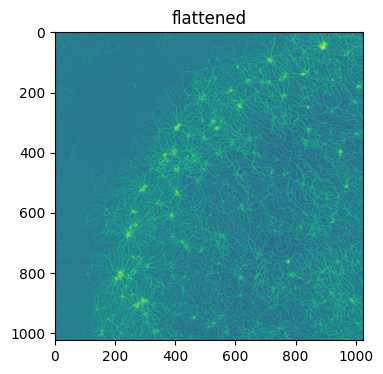

thresholds: defaultdict(None, {'upper': 0.17760540500874214})
[Fri, 31 Mar 2023 17:11:10] [INFO    ] [topostats] [None] : Masking (upper) Threshold: 0.17760540500874214


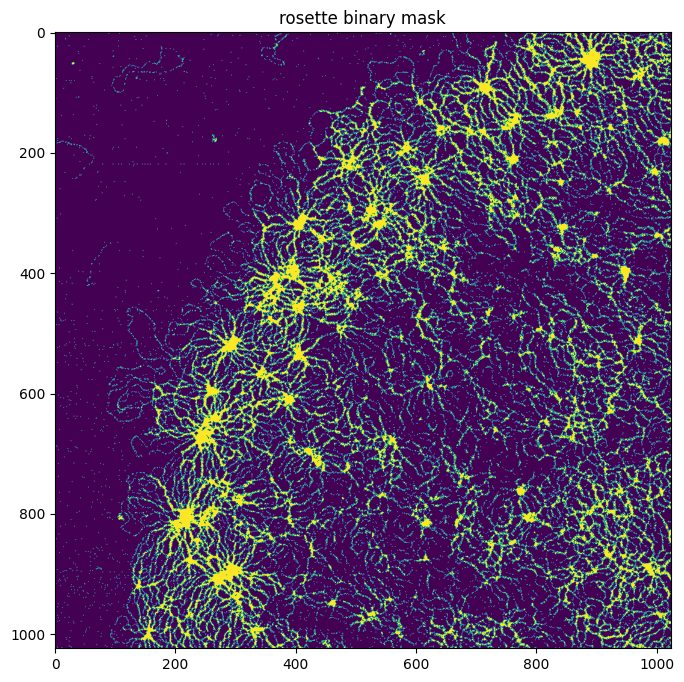

In [37]:
flattened = filters.images['zero_average_background']
plot(flattened, title='flattened',figsize=(4,4))

strand_thresholds = topofilters.get_thresholds(
    flattened,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 0.0001, 'lower': None}
)

print(f'thresholds: {strand_thresholds}')
strand_mask = topofilters.get_mask(image=flattened, thresholds=strand_thresholds)
plot(strand_mask.astype(bool), title='strand binary mask', zlimit=False)

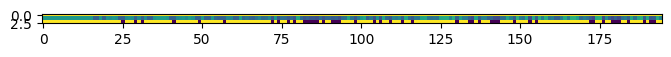

In [53]:
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(strand_mask, theta=tested_angles)
lines = hough_line_peaks(h, theta, d, num_peaks = 300,threshold = math.ceil(0.5*np.max(h[:])))

plot(lines)

In [54]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# read the image into Python and convert it to grayscale
I = cv2.imread('20230126_KPN005_00006.png')
IgrayI = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
Igray = cv2.bitwise_not(IgrayI)
plt.imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))

# We will clean it up with a few morphological operations
Ibw = cv2.threshold(Igray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
se = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 200))
cleanI = cv2.dilate(cv2.bitwise_not(Ibw), se)
plt.imshow(cv2.cvtColor(cleanI, cv2.COLOR_BGR2RGB))

# Perform a Hough Transform on the image The Hough Transform identifies lines in an image
H, theta, rho = cv2.HoughLines(cleanI, 1, np.pi / 180, 200)
P = cv2.HoughPeaks(H, 300, threshold=int(0.5 * H.max()), min_distance=0)

# the cv2.lines function defines how to draw the lines.
# Variable parameters are: minLineLength defines the minimum size of a marked line. MaxLineGap defines the maximum space between two lines. The numbers were optimized using the set of images available.
lines = cv2.HoughLinesP(cleanI, 1, np.pi / 180, threshold=int(0.5 * H.max()), minLineLength=15, maxLineGap=3)

# Plot the lines on top of image marking the beginning and end
plt.imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
for line in lines:
    x1, y1, x2, y2 = line[0]
    plt.plot([x1, x2], [y1, y2], 'g-', linewidth=2)

# To be able to plot the angles using the plt.polar function, it is necessary to transform all the degree values of theta to radians using np.deg2rad.
plt.figure()
angles = []
for line in lines:
    x1, y1, x2, y2 = line[0]
    theta = np.arctan2(y2 - y1, x2 - x1)
    angles.append(theta)
plt.polar(angles, np.ones(len(angles)), 'ro')

plt.show()

ModuleNotFoundError: No module named 'cv2'